In [1]:
import importlib
import network
importlib.reload(network)

<module 'network' from 'C:\\Users\\binhe\\Documents\\steg\\network.py'>

In [2]:
import os
from random import shuffle
from torchvision.transforms import ToPILImage
import torchvision.transforms as transforms
from torchvision import datasets, utils
import pickle
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch import utils
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

In [3]:
import glob
import random
import PIL
if not os.path.exists("statistics.pkl"):
    files = glob.glob("images/**/*.jpg")
    subset = random.choices(files, k=3000)
    images = []
    for im in subset:
        with PIL.Image.open(im) as f:
            images.append(np.asarray(f) / 256)
    arr = np.stack(images)
    mean = arr.mean(axis=(0, 1, 2))
    std = arr.std(axis=(0, 1, 2))
    with open('statistics.pkl', 'wb+') as stat:
        pickle.dump((mean, std), stat)
else:
    with open('statistics.pkl', 'rb') as stat:
        print("READING")
        mean, std = pickle.load(stat)
print(mean, std)


READING
[0.42716227 0.45460954 0.44991944] [0.2543999  0.2460573  0.27638961]


In [4]:
def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

In [5]:
batch_size = 2
num_workers = 2

In [6]:
secret_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        'images/',
        transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])), batch_size=batch_size, num_workers=num_workers,
    pin_memory=True, shuffle=True, drop_last=True)
cover_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        'images/',
        transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean,
                                 std=std)
        ])), batch_size=batch_size, num_workers=num_workers,
    pin_memory=True, shuffle=True, drop_last=True)

In [7]:
deep_net_2 = network.DeepNet()
deep_res_net = network.DeepResidualNet()

In [11]:
learning_rate = 0.001
beta = 1

In [53]:
opt1 = optim.Adam(deep_net_2.parameters(), lr=learning_rate)
opt2 = optim.Adam(deep_res_net.parameters(), lr=learning_rate)

In [54]:
def train_model(net, optimizer, secret_loader, cover_loader, beta, learning_rate, num_epochs=1, prefix='deep'):

    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()

        train_losses = []
        # Train one epoch
        for idx, (train_secret, train_cover) in enumerate(zip(secret_loader, cover_loader)):
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            # this is the cover the recovered secret
            train_hidden, train_output = net(train_secret[0], train_cover[0])
            
            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = network.customized_loss(
                 train_output, train_hidden, train_secret[0], train_cover[0], beta)
            train_loss.backward()
            optimizer.step()

            # Saves training loss
            train_losses.append(train_loss.item())
            loss_history.append(train_loss.item())

            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(
                idx+1, len(secret_loader), train_loss.item(), train_loss_cover.item(), train_loss_secret.item()))
            if idx > 60:
                break

        torch.save(net, f'models/{prefix}-epoch-N{epoch+1}.pkl')

        mean_train_loss = np.mean(train_losses)

        # Prints epoch average loss
        print('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
            epoch+1, num_epochs, mean_train_loss))

    return net, mean_train_loss, loss_history

Run the following many times

In [135]:
deep_net_2, mean_train_loss, loss_history = train_model(deep_net_2, opt1, secret_loader, cover_loader, beta, learning_rate, prefix='deep-3')

Training: Batch 1/2688. Loss of 0.1689, cover loss of 0.0695, secret loss of 0.0995
Training: Batch 2/2688. Loss of 0.1192, cover loss of 0.0308, secret loss of 0.0885
Training: Batch 3/2688. Loss of 0.1994, cover loss of 0.0493, secret loss of 0.1501
Training: Batch 4/2688. Loss of 0.4460, cover loss of 0.0663, secret loss of 0.3797
Training: Batch 5/2688. Loss of 0.1391, cover loss of 0.0444, secret loss of 0.0947
Training: Batch 6/2688. Loss of 0.1229, cover loss of 0.0313, secret loss of 0.0916
Training: Batch 7/2688. Loss of 0.1217, cover loss of 0.0253, secret loss of 0.0964
Training: Batch 8/2688. Loss of 0.2426, cover loss of 0.0711, secret loss of 0.1716
Training: Batch 9/2688. Loss of 0.2796, cover loss of 0.0465, secret loss of 0.2330
Training: Batch 10/2688. Loss of 0.1547, cover loss of 0.0423, secret loss of 0.1124
Training: Batch 11/2688. Loss of 0.3052, cover loss of 0.0447, secret loss of 0.2605
Training: Batch 12/2688. Loss of 0.1003, cover loss of 0.0271, secret loss

In [ ]:
deep_res_net, mean_train_loss, loss_history = train_model(deep_res_net, opt2, secret_loader, cover_loader, beta, learning_rate, prefix='deep_res-1')

Training: Batch 1/2688. Loss of 0.2930, cover loss of 0.0196, secret loss of 0.2735
Training: Batch 2/2688. Loss of 0.2486, cover loss of 0.0320, secret loss of 0.2166
Training: Batch 3/2688. Loss of 0.2274, cover loss of 0.0578, secret loss of 0.1695
Training: Batch 4/2688. Loss of 0.3353, cover loss of 0.0452, secret loss of 0.2901
Training: Batch 5/2688. Loss of 0.1329, cover loss of 0.0486, secret loss of 0.0843
Training: Batch 6/2688. Loss of 0.1502, cover loss of 0.0353, secret loss of 0.1149
Training: Batch 7/2688. Loss of 0.2164, cover loss of 0.0499, secret loss of 0.1666
Training: Batch 8/2688. Loss of 0.2869, cover loss of 0.0244, secret loss of 0.2625
Training: Batch 9/2688. Loss of 0.1587, cover loss of 0.0332, secret loss of 0.1255
Training: Batch 10/2688. Loss of 0.2313, cover loss of 0.0202, secret loss of 0.2110
Training: Batch 11/2688. Loss of 0.1008, cover loss of 0.0223, secret loss of 0.0785
Training: Batch 12/2688. Loss of 0.1396, cover loss of 0.0558, secret loss

In [121]:
deep_net_2.eval()

secret = next(iter(secret_loader))
cover = next(iter(cover_loader))

In [122]:
hidden, reveal = deep_net_2(secret[0][0, :, :, :].unsqueeze(0), cover[0][0, :, :, :].unsqueeze(0))

In [123]:
hidden = denormalize(hidden.squeeze(0), std, mean)
reveal = denormalize(reveal.squeeze(0), std, mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


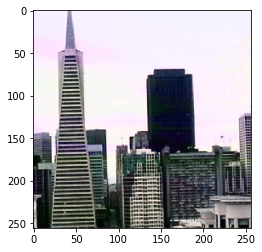

In [124]:
plt.imshow(hidden.detach().numpy().transpose([1, 2, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


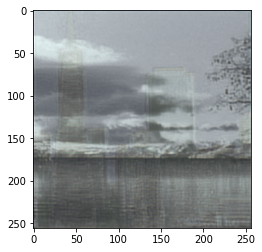

In [125]:
plt.imshow(reveal.detach().numpy().transpose([1, 2, 0]))

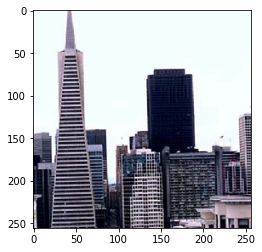

In [126]:
plt.imshow(denormalize(cover[0][0], std, mean).numpy().transpose([1, 2, 0]))

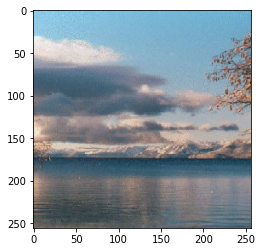

In [127]:
plt.imshow(denormalize(secret[0][0], std, mean).numpy().transpose([1, 2, 0]))

In [128]:
deep_res_net.eval()

secret = next(iter(secret_loader))
cover = next(iter(cover_loader))

hidden, reveal = deep_res_net(secret[0][0, :, :, :].unsqueeze(0), cover[0][0, :, :, :].unsqueeze(0))
hidden = denormalize(hidden.squeeze(0), std, mean)
reveal = denormalize(reveal.squeeze(0), std, mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


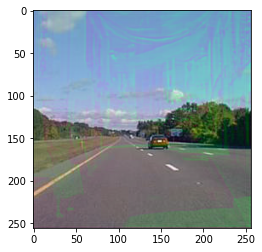

In [129]:
plt.imshow(hidden.detach().numpy().transpose([1, 2, 0]))

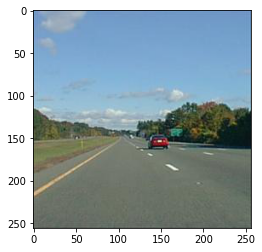

In [130]:
plt.imshow(denormalize(cover[0][0], std, mean).numpy().transpose([1, 2, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


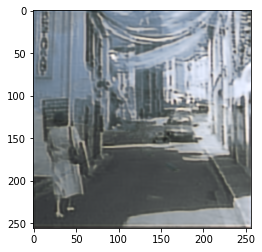

In [131]:
plt.imshow(reveal.detach().numpy().transpose([1, 2, 0]))

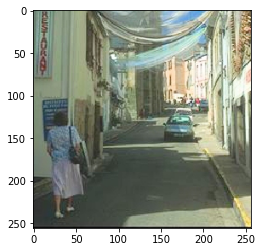

In [132]:
plt.imshow(denormalize(secret[0][0], std, mean).numpy().transpose([1, 2, 0]))